# Introduction

Brett Wisniewski

**Disclaimer**:
BE SURE TO LOOK AT THE README, WATCH THE VIDEO, READ THE PAPER BEFORE LOOKING AT THIS IT HAS ALL THE INFORMATION THAT WILL MAKE SENSE. I WOULD ALSO RECOMMEND READING THE PAPER PRIOR TO LOOKING AT THESE NOTEBOOKS


This is our data preprocessing step. Unfortunately, for the preprocessing step, it will be imposible for the grader to be able to actually run the code. This is due to the sheer volume of data that is prior to training. It is hours of audiovisual content that I am unable to provide (unable to fit in its entirety on my GitHub). However, I will walk you through the steps to be preprocess the data (and what it all means) even if you cannot do it yourself.


This project is apart of the ISAT lab for Professor Nathaniel Blanchard. This project was submitted to the HCII conference.







# Verbal

So below is an example of a temporal transcript file from Google (from the weights task) before data preprocessing. As you can notice, there is a sentence, but this isn't enough as we want numerical features to feed to our machine learning algorithms:

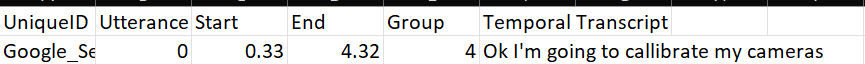

So there are six features total:
To explain each:
1. UniqueID: This corresponds to the ASR system in place
2. Utterance: What number utterance it is
3. Start: The time a person started speaking
4. End: The time a person ended speaking.
5. Group: One for each of the ten groups in the weighs task
6. Temporal Transcript: These are the actual sentences spoken during the weights task. This is the actual data itself and what we will turn into bert embeddings

First, we need labels. We basically want to assign labels to our data so that the machine learning model can actually evaluate it properly. The meaning of the labels is explained in the paper.

To create our Verbal features, we essentially want to run it through the BERT model (see the paper) in order to create tensors out of the sentence data (currently represented as the Temporal Transcript)


The research lab had timestamps that were associated with the labels. We had labels based on timestamps for the Weights task dataset. Our research on CPS has a labelling scheme that we wish to use to label our data. This labelling scheme splits the labels into one of three categories. The three labels are: construction of shared knowledge, negotiation/coordination, and maintaining team function (explained much more in the paper). Each of these labels represent a different CPS behavior that will be evaluated. The code below is assigning the labels automatically so it didn't need to be done by hand


In [ ]:
import pandas as pd

def label_transcripts(transcripts_file_path, labels_file_path, output_file_path):
    sentences_df = pd.read_csv(transcripts_file_path)
    labels_df = pd.read_csv(labels_file_path)
    labeled_sentences = sentences_df.copy()

    for label_column in labels_df.columns.difference(['Start', 'End', 'Group', 'Participant']):
        labeled_sentences[label_column] = None

    for _, label_row in labels_df.iterrows():
        label_start = label_row['Start']
        label_end = label_row['End']

        overlapping_sentences = labeled_sentences[
            ((labeled_sentences['Start'] >= label_start) & (labeled_sentences['Start'] < label_end)) |
            ((labeled_sentences['End'] > label_start) & (labeled_sentences['End'] <= label_end)) |
            ((labeled_sentences['Start'] <= label_start) & (labeled_sentences['End'] >= label_end))
        ]

        for column in labels_df.columns:
            if column not in ['Start', 'End', 'Group', 'Participant']:
                labeled_sentences.loc[overlapping_sentences.index, column] = label_row[column]

    labeled_sentences.to_csv(output_file_path, index=False)

    return output_file_path

output_path = label_transcripts(
    '/content/TemporalTranscript4.csv',
    '/content/Group_04_CPS.csv',
    '/content/Output_Labeled_Transcript.csv'
)
print(f"Labeled transcript saved to: {output_path}")

After this code, our updated file (with the labels) looks like this:

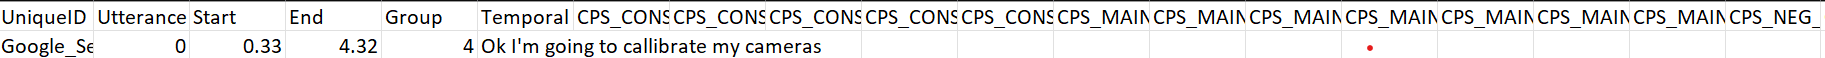.

Some labels have been assigned towards these sentences. As you can see, there are three labels, however, each label has multiple of the same kind. This is by design, and during the training process, this is accounted for (each label with multiple of the same kind are combined together as one). It is because in CPS, even though there are three labels, some of these labels have multiple of the same type.

We have the our labels correctly created. However, our feature matrix has the problem of having only one notable feature that it can train off of: The sentence feature. A normal sentence is not enough for a tradional classifier to work with.   Now we can turn our sentences into verbal features using BERT. The sentence will essentially become a giant tensor where it will be easy for the machine learning model to interpret. Verbal features and BERT is explained thoroughly in the paper





In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from transformers import BertTokenizer

df = pd.read_csv('/content/TemporalTranscript4.csv')


def preprocess_text(text):

    text = str(text)
    text = text.replace('\n', ' ').replace('.', '')
    preprocessed_text = '[CLS] ' + text + ' [SEP]'
    return preprocessed_text



df['preprocessed_text'] = df['Temporal Transcript'].apply(preprocess_text)
print(df['preprocessed_text'])




import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_sentence_embeddings(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**tokens)
    sentence_embedding = torch.mean(outputs.last_hidden_state, dim=1)
    return sentence_embedding

df['sentence_embedding'] = df['preprocessed_text'].apply(get_sentence_embeddings)

print(df['sentence_embedding'])


df.to_csv('temporalbert4.csv', index=False)

0      [CLS] Ok I'm going to callibrate my cameras [SEP]
1                                        [CLS] nan [SEP]
2                                        [CLS] nan [SEP]
3      [CLS] I'm sorry I feel like this didn't catch ...
4                                         [CLS] Ok [SEP]
                             ...                        
121    [CLS] Fibo oh that looks pretty good actually ...
122    [CLS] No no there's how do you spell fibonacci...
123               [CLS] I think it's F O it's that [SEP]
124    [CLS] We can also look it up I think this is r...
125    [CLS] I don't know I'm just going to leave it ...
Name: preprocessed_text, Length: 126, dtype: object


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

0      [[tensor(0.4039), tensor(0.0822), tensor(0.323...
1      [[tensor(0.3310), tensor(-0.0837), tensor(-0.0...
2      [[tensor(0.3310), tensor(-0.0837), tensor(-0.0...
3      [[tensor(0.2072), tensor(-0.0597), tensor(0.15...
4      [[tensor(0.3396), tensor(0.0391), tensor(-0.04...
                             ...                        
121    [[tensor(0.1875), tensor(-0.0641), tensor(0.27...
122    [[tensor(0.2914), tensor(0.1339), tensor(0.464...
123    [[tensor(0.1566), tensor(0.3158), tensor(0.393...
124    [[tensor(0.0135), tensor(-0.1656), tensor(0.36...
125    [[tensor(0.3336), tensor(-0.1403), tensor(0.51...
Name: sentence_embedding, Length: 126, dtype: object


**After the code has been ran, two features have been added to our feature matrix below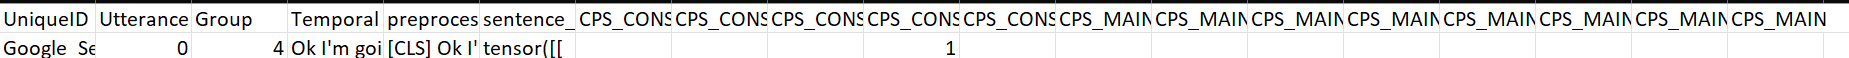**   

These two features are preprocess and sentence_embedding. The preprocess was for the BERT model and is left in the matrix for the reason that if we need to run it through BERT again in the future, it is easier. The sentence_embeddings are the most important feature as they are what the machine learning model will learn off of. As explained above before the code block, they are a tensor that represents the sentence in numerical form. We wish for the model to train off of these. However, the problem is that the bert embeddings are all inside of one feature where we want them to be spread out. Our solution to this problem is to use a process called "flattening" that will turn the tensor into a series of 512 columns per row that the model will use to learn off of



In [ ]:
flattened_embedding = sentence_embedding.view(-1, 512)

df['flattened_embedding'] = df['preprocessed_text'].apply(get_sentence_embeddings)

print(df['flattened_embedding'])

df.to_csv('/content/temporalbert4_flattened.csv', index=False)

This code will now take each tensor and split it into 512 features (which is the length of each tensor). The result is pictured below:

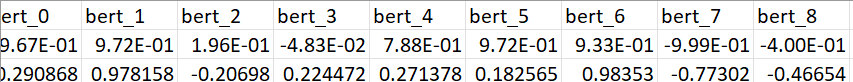

A snippet of the flattened tensor was shown and it illustrates how each line in the original tensor is now it's own column. Each row now has 512 features per row which gives the machine learning classifiers more than enough information to work with. Using this, our feature matrix and labels now have the correct information
We now want to show our full dataset, but first, we will make it a pandas dataframe to simplify the visuals:


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
hunting_set_file = hunting_set_file = r"/content/Temporal_Whisper_Verbal.csv" # this is the path to our finished file
df_hunting = pd.read_csv(hunting_set_file)
df_hunting.dtypes

<ipython-input-2-e91e47a0028d>:4: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hunting = pd.read_csv(hunting_set_file)


,0
utteranceID,object
Group,object
CPS_CONST_EstablishesCG_Confirms,float64
CPS_CONST_EstablishesCG_Interrupts,float64
CPS_CONST_SharesU_CorrectSolutions,float64
...,...
bert_embedding_764,float64
bert_embedding_765,float64
bert_embedding_766,float64
bert_embedding_767,float64


In [ ]:
df_hunting

utteranceID     Group  CPS_CONST_EstablishesCG_Confirms  \
0       Group_01  Group_01                               NaN   
1       Group_01  Group_01                               NaN   
2       Group_01  Group_01                               NaN   
3       Group_01  Group_01                               NaN   
4       Group_01  Group_01                               NaN   
...          ...       ...                               ...   
2950    Group_10  Group_10                               NaN   
2951    Group_10  Group_10                               NaN   
2952    Group_10  Group_10                               NaN   
2953    Group_10  Group_10                               NaN   
2954    Group_10  Group_10                               NaN   

      CPS_CONST_EstablishesCG_Interrupts  CPS_CONST_SharesU_CorrectSolutions  \
0                                    NaN                                 NaN   
1                                    NaN                                 NaN   
2                                    NaN                                 NaN   
3                                    NaN                                 NaN   
4                                    NaN                                 NaN   
...                                  ...                                 ...   
2950                                 NaN                                 NaN   
2951                                 NaN                                 NaN   
2952                                 NaN                                 NaN   
2953                                 NaN                                 NaN   
2954                                 NaN                                 NaN   

     CPS_CONST_SharesU_IncorrectSolutions  CPS_CONST_SharesU_Situation  \
0                                     NaN                          NaN   
1                                     NaN                          NaN   
2                                     NaN                          NaN   
3                                     NaN                          NaN   
4                                     NaN                          NaN   
...                                   ...                          ...   
2950                                  NaN                          NaN   
2951                                  NaN                          NaN   
2952                                  NaN                          NaN   
2953                                  NaN                          NaN   
2954                                  NaN                          NaN   

      CPS_MAINTAIN_FulfillsR_Apologizes  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   
...                                 ...   
2950                                NaN   
2951                                NaN   
2952                                NaN   
2953                                NaN   
2954                                NaN   

      CPS_MAINTAIN_FulfillsR_InitiatesOffTopic  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
...                                        ...   
2950                                       NaN   
2951                                       NaN   
2952                                       NaN   
2953                                       NaN   
2954                                       1.0   

      CPS_MAINTAIN_FulfillsR_JoinsOffTopic  CPS_MAINTAIN_FulfillsR_Support  \
0                                      NaN                             NaN   
1                                      NaN                             NaN   
2                                 

This dataframe shows the first 5 rows and the last 5 rows. The first two columns are for organization reasons. The next several columns are the labels. Keep in mind that there are only three lables technically (CPS_CONST, CPS_NEG, CPS_MAINTAIN). However, each label can have multiple sub categories. Any NAN label is actually a 0 (our training code takes this into account). Once you scroll further to the right, you can find the 512 bert features per row. These are the main features that the model will use to train off of.



Our feature matrix and label vector are now complete, however, they are still in one dataframe together. We want to split them into X and y and convert them to numpy. The following code will do that. We have also included a print out of the feature names and the label names to show what X and y include



In [ ]:
#Features from the dataset

X = df_hunting.iloc[:, 21:]
print(X.columns)
X = X.to_numpy()

Index(['bert_embedding_1', 'bert_embedding_2', 'bert_embedding_3',
       'bert_embedding_4', 'bert_embedding_5', 'bert_embedding_6',
       'bert_embedding_7', 'bert_embedding_8', 'bert_embedding_9',
       'bert_embedding_10',
       ...
       'bert_embedding_759', 'bert_embedding_760', 'bert_embedding_761',
       'bert_embedding_762', 'bert_embedding_763', 'bert_embedding_764',
       'bert_embedding_765', 'bert_embedding_766', 'bert_embedding_767',
       'bert_embedding_768'],
      dtype='object', length=768)


# Prosodic


This is the code we will use to generate our Prosodic data. You will be unable to run it as it requires the raw video data which was much to large to upload to the github repo. It also requires external lab setup that is too difficult for grading. It is very difficult to set this up locally. For BERT I provided a much more in depth analysis. For prosodic, it is much shorter so less of an analysis was given


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import opensmile

In [ ]:
import configparser

def read_ini(file_path):
    config = configparser.ConfigParser()
    config.read(file_path)
    dataDir = config["paths"]["dataDir"]
    groups = config["paths"]["groups"].split()
    segmentDir = config["audio"]["segmentDir"]
    for group in range(len(groups)):
        groups[group] = os.path.join(dataDir, groups[group])
    return groups, segmentDir

groups, segmentDir = read_ini("config (1).ini")

The code here basically does all of the setup for OpenSMile. we are extraiing features using feature_set and smile.feature_names allows us to print the names of the extracted features.

In [ ]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
print(smile.feature_names)

The code here iteratres over each groups. Groups is a list of session directories that each representes a group of segmented audio files. os.path.basename(sess) will extract each sessions' basename (such as Group1). os.path.join(sess, segmentDir) then consturcts a path to the directoru containing segmented audio files for this session.

In [ ]:
for sess in groups:
    group = os.path.basename(sess)
    print("Running ", group)
    segaudio = os.path.join(sess, segmentDir)
    segaudio = segaudio.replace('\\', '/')
    print(segaudio)
    y = smile.process_folder(str(segaudio), filetype='wav')
    y.to_csv(os.path.join(sess, f"example_{group}_{segmentDir}_opensmile.csv"))

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
hunting_set_file = hunting_set_file = r"/content/Temporal_Oracle_Prosodic.csv" # this is the path to our finished file
df_hunting = pd.read_csv(hunting_set_file)
df_hunting.dtypes

,0
utteranceID,object
Group,object
CPS_CONST_SharesU_Situation,float64
CPS_CONST_SharesU_CorrectSolutions,float64
CPS_CONST_SharesU_IncorrectSolutions,float64
...,...
MeanVoicedSegmentLengthSec,float64
StddevVoicedSegmentLengthSec,float64
MeanUnvoicedSegmentLength,float64
StddevUnvoicedSegmentLength,float64


Several features of the prosodic data is shown after OpenSmile generation. An example of one is the MeanUnvoicedSegmentLength

In [2]:
df_hunting

,utteranceID,Group,CPS_CONST_SharesU_Situation,CPS_CONST_SharesU_CorrectSolutions,CPS_CONST_SharesU_IncorrectSolutions,CPS_CONST_EstablishesCG_Confirms,CPS_CONST_EstablishesCG_Interrupts,CPS_NEG_Responds_Reasons,CPS_NEG_Responds_QuestionsOthers,CPS_NEG_Responds_Responds,CPS_NEG_MonitorsE_Results,CPS_NEG_MonitorsE_Strategizes,CPS_NEG_MonitorsE_Save,CPS_NEG_MonitorsE_GivingUp,CPS_MAINTAIN_Initiative_Suggestions,CPS_MAINTAIN_Initiative_Compliments,CPS_MAINTAIN_Initiative_Criticizes,CPS_MAINTAIN_FulfillsR_Support,CPS_MAINTAIN_FulfillsR_Apologizes,CPS_MAINTAIN_FulfillsR_InitiatesOffTopic,CPS_MAINTAIN_FulfillsR_JoinsOffTopic,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,mfcc3_sma3_amean,mfcc3_sma3_stddevNorm,mfcc4_sma3_amean,mfcc4_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amean,shimmerLocaldB_sma3nz_stddevNorm,HNRdBACF_sma3nz_amean,HNRdBACF_sma3nz_stddevNorm,logRelF0-H1-H2_sma3nz_amean,logRelF0-H1-H2_sma3nz_stddevNorm,logRelF0-H1-A3_sma3nz_amean,logRelF0-H1-A3_sma3nz_stddevNorm,F1frequency_sma3nz_amean,F1frequency_sma3nz_stddevNorm,F1bandwidth_sma3nz_amean,F1bandwidth_sma3nz_stddevNorm,F1amplitudeLogRelF0_sma3nz_amean,F1amplitudeLogRelF0_sma3nz_stddevNorm,F2frequency_sma3nz_amean,F2frequency_sma3nz_stddevNorm,F2bandwidth_sma3nz_amean,F2bandwidth_sma3nz_stddevNorm,F2amplitudeLogRelF0_sma3nz_amean,F2amplitudeLogRelF0_sma3nz_stddevNorm,F3frequency_sma3nz_amean,F3frequency_sma3nz_stddevNorm,F3bandwidth_sma3nz_amean,F3bandwidth_sma3nz_stddevNorm,F3amplitudeLogRelF0_sma3nz_amean,F3amplitudeLogRelF0_sma3nz_stddevNorm,alphaRatioV_sma3nz_amean,alphaRatioV_sma3nz_stddevNorm,hammarbergIndexV_sma3nz_amean,hammarbergIndexV_sma3nz_stddevNorm,slopeV0-500_sma3nz_amean,slopeV0-500_sma3nz_stddevNorm,slopeV500-1500_sma3nz_amean,slopeV500-1500_sma3nz_stddevNorm,spectralFluxV_sma3nz_amean,spectralFluxV_sma3nz_stddevNorm,mfcc1V_sma3nz_amean,mfcc1V_sma3nz_stddevNorm,mfcc2V_sma3nz_amean,mfcc2V_sma3nz_stddevNorm,mfcc3V_sma3nz_amean,mfcc3V_sma3nz_stddevNorm,mfcc4V_sma3nz_amean,mfcc4V_sma3nz_stddevNorm,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,Group_01_0,Group_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.396194,0.338280,14.892636,33.875412,37.278744,22.386108,862.487060,983.041600,63.726864,52.812996,0.274130,0.794935,0.123700,0.203631,0.366149,0.242449,3.112466,2.290912,2.688216,2.206990,0.114136,0.852061,22.000206,0.440444,11.625559,1.026636,12.471546,0.727588,-6.650619,-2.452583,0.051049,2.077099,1.125676,0.622610,3.091460,2.337315,7.151475,2.925005,23.514091,0.564082,502.92426,0.298691,1156.29490,0.170739,-77.290650,-1.134085,1635.2410,0.132523,850.69836,0.563978,-86.539850,-0.895308,2680.0890,0.101992,768.49180,0.434191,-87.158270,-0.880733,-17.622890,-0.285781,24.515156,0.307184,0.012989,2.629898,-0.026570,-0.435329,0.142307,0.785790,26.076118,0.312339,9.053426,1.401079,11.703502,0.862760,-12.987155,-1.281663,-13.438

Scroll all the way to the right to see all of the Prosodic data
